In [1]:
print('Meu nome é: Gabriel Moraes Barros ')
print('Meu RA é: 192801')

Meu nome é: Gabriel Moraes Barros 
Meu RA é: 192801


In [2]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import sys
import numpy as np
import numpy.random as nr

import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import (SGD, 
                              RMSprop, 
                              Adam, 
                              Adadelta, 
                              Adagrad)

print('Keras ', keras.__version__)

Using TensorFlow backend.


Keras  2.0.5


In [3]:
import os
os.makedirs('../models', exist_ok=True)
nr.seed(20170603)

In [4]:
!ls ../utils

my_keras_utilities.py  __pycache__


In [5]:
sys.path.append('../utils')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter, train_network)


### Testa se um modulo foi importado

In [6]:
'my_keras_utilities' in sys.modules



True

try:
    train_network(model_week05, model_name, train_generator, validation_generator, **fit_params);
except AttributeError:
      print('nope')

In [7]:
import keras.backend as K
K.set_image_data_format('channels_first')
K.set_floatx('float32')
print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
!nvidia-smib

Backend:        tensorflow
Data format:    channels_first
/bin/sh: 1: nvidia-smib: not found


In [8]:
!ls ../Task\ 5

ls: cannot access '../Task 5': No such file or directory


## Função auxiliar

## Subindo o dataset

In [9]:
#auternar o comentário, se estiver no client ou no remote
data = np.load('/etc/jupyterhub/ia368z_2s2017/datasets/cifar10-redux.npz')
#data = np.load('../Task 5/cifar10-redux.npz')

In [10]:
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

In [11]:
X_train.dtype, y_train.dtype, X_test.dtype, y_test.dtype

(dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('int64'))

### Separando o conjunto de treinamento em validação e treinamento, numa proporção 80/20 %


In [12]:
p=np.random.permutation(len(X_train))
percent_factor=0.85
new_train_x = X_train[p]
new_train_y = y_train[p]


new_X_train = new_train_x[0:(np.floor(len(new_train_x)*percent_factor))]
new_y_train = new_train_y[0:(np.floor(len(new_train_y)*percent_factor))]
new_X_val = new_train_x[(np.ceil(len(new_train_x)*percent_factor)):]
new_y_val = new_train_y[(np.ceil(len(new_train_y)*percent_factor)):]


/home/adessowiki/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/adessowiki/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/adessowiki/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/adessowiki/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [13]:
print('X_train.shape',new_X_train.shape)
print('y_train.shape',new_y_train.shape)
print('X_val.shape',new_X_val.shape)
print('y_val.shape',new_y_val.shape)
print('y_test shape ',y_test.shape)
print('X_test.shape:',X_test.shape)


X_train.shape (1700, 3, 32, 32)
y_train.shape (1700,)
X_val.shape (300, 3, 32, 32)
y_val.shape (300,)
y_test shape  (500,)
X_test.shape: (500, 3, 32, 32)


In [14]:
print('Número de diferentes classes',len(np.unique(y_test)))


Número de diferentes classes 3


Normalizando os dados

In [15]:
a=0
print(np.mean(X_train))

113.781868652


In [16]:
#Guaranteeing that it only runs once
if (a==0):
    X_test = X_test.astype('float32')
    new_X_train = new_X_train.astype('float32')
    new_X_val = new_X_val.astype('float32')
    
    new_X_val /= 255.
    new_X_train /= 255.
    X_test /= 255.
    
    a=1
print(np.mean(new_X_train))
print(np.mean(new_X_val))
print(np.mean(X_test))

0.445836
0.448282
0.458465


In [17]:
from keras.utils import np_utils

## Transforma o vetor de labels para o formato de one-hot encoding.
n_classes = 3
y_train_oh = np_utils.to_categorical(new_y_train-3, n_classes)
y_val_oh = np_utils.to_categorical(new_y_val-3, n_classes)
y_test_oh = np_utils.to_categorical(y_test-3, n_classes)

In [18]:
print(y_train_oh.shape)
print(y_val_oh.shape)
print(y_test_oh.shape)


(1700, 3)
(300, 3)
(500, 3)


## Fazendo o data augmentation

In [19]:
print(X_train.shape)
print(X_test.shape)

(2000, 3, 32, 32)
(500, 3, 32, 32)


In [20]:
print('new x train shape', new_X_train.shape)
print('y train oh shape', y_train_oh.shape)

print('new x val shape', new_X_val.shape)
print('y val oh shape', y_val_oh.shape)



new x train shape (1700, 3, 32, 32)
y train oh shape (1700, 3)
new x val shape (300, 3, 32, 32)
y val oh shape (300, 3)


In [21]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
nb_train_samples = new_train_x.shape[0]
nb_val_samples = new_X_val.shape[0]
print('nb val samples',nb_val_samples)
nb_test_samples = X_test.shape[0]

# dimensions of our images.
img_width, img_height = 32, 32
batch_size=50
# this is the augmentation configuration we will use for training

r(
       #rescale=1./255,         # sempre faz o rescale
       shear_range=0.2,        # sorteio entre 0 e 0.2 distribuição uniforme
       zoom_range=0.2,         # sorteio entre 0 e 0.2
       horizontal_flip=True)   # sorteio 50%

test_datagen = ImageDataGenerator(rescale = 1/1.)
        #shear_range=0.2,        # sorteio entre 0 e 0.2 distribuição uniforme
       #zoom_range=0.2,         # sorteio entre 0 e 0.2
       #horizontal_flip=True)   # sorteio 50%

train_generator = train_datagen.flow(
        new_X_train,y_train_oh,                       # as amostras de treinamento
        batch_size=batch_size                # batch size do SGD
    )

validation_generator = train_datagen.flow(
        new_X_val, y_val_oh,                  # as amostras de validação
        batch_size=batch_size)

nb val samples 300


In [22]:
test_generator = test_datagen.flow(
        X_test, y_test_oh,                  # as amostras de validação
        batch_size=batch_size)

In [23]:
#Conjunto de treinaemnto
samples_train = train_datagen.flow(new_X_train)
n_samples_train = nb_train_samples/batch_size

#Conjunto de teste
samples_test = train_datagen.flow(X_test)
n_samples_test = nb_test_samples/batch_size
#Conjunto de validacao

samples_val = train_datagen.flow(new_X_val)
n_samples_val = nb_val_samples/batch_size

In [24]:
n_classes = len(np.unique(y_test))
print(n_classes)

3


# Transfer_Learning


## Subindo a VGG-16

In [25]:
from keras.applications.vgg16 import VGG16
modelvgg = VGG16(include_top=False, weights='imagenet')


/home/adessowiki/anaconda3/lib/python3.6/site-packages/keras/applications/vgg16.py:181: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image data format convention (`image_data_format="channels_first"`). For best performance, set `image_data_format="channels_last"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


In [26]:
modelvgg.layers.pop(18)
modelvgg.layers.pop(17)
modelvgg.layers.pop(16)
modelvgg.layers.pop(15)

In [ ]:
#modelvgg.summary()

In [27]:
train_features = modelvgg.predict(new_X_train)
print('train_features shape and type',train_features.shape,train_features.dtype)
validation_features = modelvgg.predict(new_X_val)
print('validation_features shape and type',validation_features.shape,train_features.dtype)
test_features = modelvgg.predict(X_test)
print('test_features shape and type',test_features.shape,train_features.dtype)

train_features shape and type (1700, 512, 1, 1) float32
validation_features shape and type (300, 512, 1, 1) float32
test_features shape and type (500, 512, 1, 1) float32


In [28]:
train_features.shape[1:]

(512, 1, 1)

In [29]:
model_name = '../cifar_redux_augmented_vgg'

modelVGG = Sequential()
modelVGG.add(Flatten(input_shape= train_features.shape[1:]))    
modelVGG.add(Dense(120))
modelVGG.add(Activation('relu'))
modelVGG.add(Dropout(0.5))
modelVGG.add(Dense(3))
modelVGG.add(Activation('softmax'))

In [30]:
modelVGG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               61560     
_________________________________________________________________
activation_1 (Activation)    (None, 120)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 363       
_________________________________________________________________
activation_2 (Activation)    (None, 3)                 0         
Total params: 61,923
Trainable params: 61,923
Non-trainable params: 0
_________________________________________________________________


## Treinando class MyCb(TrainingPlotter):
    

In [31]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, model_name, Xtra, ytra, Xval, yval, 
                  opt='rmsprop', batch_size=100, nepochs=50, patience=50, reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs ...".format(tr_epochs))
    try:
         model.fit(Xtra, ytra, batch_size=batch_size, epochs=tr_epochs, verbose=vv, 
                      validation_data=(Xval,yval), callbacks=[cb])
    except KeyboardInterrupt:
        pass

    model, histo = load_model_and_history(model_name)
    return model, cb


def test_network(model_name, Xtest, ytest, batch_size=40):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate(Xtest, ytest, batch_size=batch_size, verbose=1)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))

In [32]:
print('train_features.shape',train_features.shape)
print('validation_features.shape',validation_features.shape)
print('test_features.shape',test_features.shape)



train_features.shape (1700, 512, 1, 1)
validation_features.shape (300, 512, 1, 1)
test_features.shape (500, 512, 1, 1)


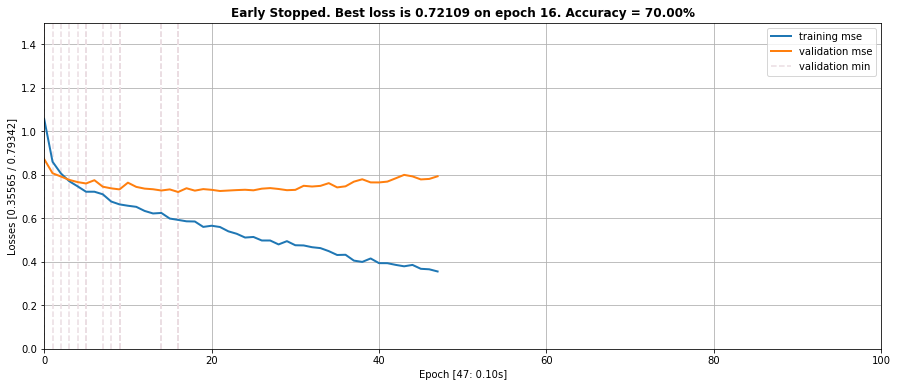

In [33]:
fit_params = {
    'opt':         'adam',           # SGD(lr=0.01, momentum=0.9, nesterov=True), 
    'nepochs':         100, 
    'patience':        30,
    'ploss':           1.5,
    'reset':           True,
}

train_network(modelVGG, model_name, train_features, y_train_oh, validation_features, y_val_oh,  **fit_params);

In [34]:
test_network(model_name, test_features,y_test_oh,X_test.shape[0])

Model from epoch 16
[INFO] evaluating in the test data set ...
500/500 [==============================] - 0s

[INFO] accuracy on the test data set: 68.00% [0.71144]
